 **Only execute in colab.**
Get kaggle api key from kaggle profile and upload it to colab.
This cell downloads bird dataset and unzips it.

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/
!kaggle datasets download -d vinayshanbhag/bird-song-data-set
!unzip -q  bird-song-data-set.zip -d dataset

kaggle.json


Mount drive in case you want to save model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns

Preparing data

In [6]:
# Creating labels
bird_labels = pd.read_csv("dataset/bird_songs_metadata.csv", usecols=['species'])
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

# Creating list of file paths
file_names = pd.read_csv("dataset/bird_songs_metadata.csv", usecols=['filename'])
file_names = np.squeeze(file_names.values)
bird_filepaths = np.array([])
for file in file_names:
    bird_filepaths = np.append(bird_filepaths, 'dataset/wavfiles/'+file)

# Splitting data into training and validation set
bird_filepaths_train, bird_filepaths_val, bird_labels_train, bird_labels_val = train_test_split(
    bird_filepaths, bird_labels, test_size=0.10, random_state=2409)

# Function that reads filepaths
def read_file(path):
    y,_ = librosa.load(path)
    return y

# Converting to db scale
def spec_to_db(y):
    y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    y=tf.numpy_function(read_file, inp= [path_tensor], Tout = tf.float32)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))
    spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    spectrogram_db = spectrogram_db/80+1
    return spectrogram_db, label

# Function that creates tf.data.Dataset with shuffle, repeat, map and batch
def make_dataset(bird_labels, bird_filepaths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    bird_filepaths = tf.convert_to_tensor(bird_filepaths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    bird_filepaths = tf.data.Dataset.from_tensor_slices(bird_filepaths)
    dataset = tf.data.Dataset.zip( bird_filepaths, bird_labels)

    if shuffle:
      dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 32, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

In [7]:
dataset_train = make_dataset(bird_labels_train, bird_filepaths_train, shuffle=True)
dataset_val = make_dataset(bird_labels_val, bird_filepaths_val, shuffle=False)

Creating model

In [12]:
def create_model():
  inputs = Input((1026, 257), name = '0_Input_shape')

  x = Conv1D(128,8,2, activation='relu', padding='same', name = '1_Conv1D')(inputs)
  x = SpatialDropout1D(0.17, name = '2_SpatialDropout1D')(x)

  x = Conv1D(128,8,2, activation='relu', padding='same', name = '3_Conv1d')(x)
  x = SpatialDropout1D(0.17, name = '4_SpatialDropout1D')(x)

  x = Conv1D(128,8,2, activation='relu', padding='same', name = '5_Conv1d')(x)
  x = SpatialDropout1D(0.17, name = '6_SpatialDropout1D')(x)

  x = Conv1D(128,8,2, activation='relu', padding='same', name = '7_Conv1d')(x)
  x = SpatialDropout1D(0.17, name = '8_SpatialDropout1D')(x)

  x = GlobalAveragePooling1D(name = '9_Global_avg_pooling')(x)
  x = Dense(512, activation='relu', name='10_Dense')(x)
  x = Dropout(0.5, name='11_Dropout')(x)
  outputs = Dense(5, name='12_Dense')(x)
  model = Model(inputs=inputs, outputs=outputs, name = 'Bird_audio_classification_model')

  return model

In [14]:
model = create_model()
model.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 1026, 257)]       0         
                                                                 
 first_Conv1D (Conv1D)       (None, 513, 128)          263296    
                                                                 
 spatial_dropout1d_4 (Spati  (None, 513, 128)          0         
 alDropout1D)                                                    
                                                                 
 second_Conv1D (Conv1D)      (None, 257, 128)          131200    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 257, 128)          0         
 alDropout1D)                                                    
                                                                 
 third_Conv1D (Conv1D)       (None,

Compiling model with learning rate schedule

In [17]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)

model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

<class 'keras.src.metrics.confusion_metrics.AUC'>


Creating callbacks

In [18]:
# Creating callbacks
logdir = 'tb_logs/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

Training model

In [20]:
training = model.fit(dataset_train, validation_data = dataset_val, epochs=100,
                     callbacks=[tensorboard_callback,model_checkpoint_callback])

Epoch 1/100
152/152 [==============================] - 82s 393ms/step - loss: 1.4005 - sparse_categorical_accuracy: 0.3236 - lr: 9.8703e-04 - val_loss: 1.2602 - val_sparse_categorical_accuracy: 0.3633 - val_lr: 9.7417e-04
Epoch 2/100
152/152 [==============================] - 65s 431ms/step - loss: 1.2415 - sparse_categorical_accuracy: 0.4128 - lr: 9.6137e-04 - val_loss: 1.1725 - val_sparse_categorical_accuracy: 0.4727 - val_lr: 9.4885e-04
Epoch 3/100
152/152 [==============================] - 83s 544ms/step - loss: 1.2045 - sparse_categorical_accuracy: 0.4494 - lr: 9.3638e-04 - val_loss: 1.0264 - val_sparse_categorical_accuracy: 0.5137 - val_lr: 9.2418e-04
Epoch 4/100
152/152 [==============================] - 71s 467ms/step - loss: 1.1083 - sparse_categorical_accuracy: 0.5093 - lr: 9.1204e-04 - val_loss: 1.0260 - val_sparse_categorical_accuracy: 0.5488 - val_lr: 9.0016e-04
Epoch 5/100
152/152 [==============================] - 63s 418ms/step - loss: 1.0516 - sparse_categorical_accura

Opens tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

Save model to drive

In [21]:
!cp -r /content/tb_logs/model /content/drive/MyDrive/tb_logs
!cp -r /content/model_checkpoint/model /content/drive/MyDrive/model_checkpoint

Evaluating model on validation dataset

In [ ]:
model_eval = tf.keras.models.load_model(checkpoint_filepath)
model_eval.evaluate(dataset_val, return_dict=True)

16/16 [==============================] - 1s 37ms/step


In [ ]:
y_logits = model_eval.predict(dataset_val)
y_prob = tf.nn.softmax(y_logits, axis=1)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(dataset_val.map(lambda s,lab: lab)), axis=0)

In [ ]:
avg_precision = average_precision_score(y_true, y_prob, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovo')
print(f"AP: {avg_precision} | F1: {f1} | Precision: {precision} | Recall: {recall} | AUC: {auc}")

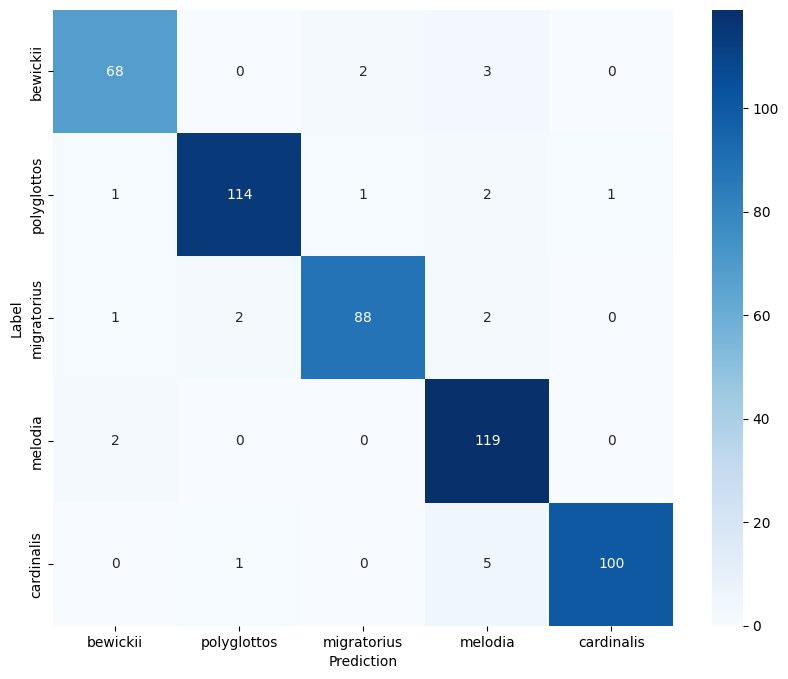

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()